In [1]:
# Load Data
import pandas as pd
from utils import get_control_clean
from utils import isc
from utils import get_w
from sklearn.neighbors import KDTree
treated = pd.read_csv('./strata/is_t_edl.csv', index_col=0)
controls = pd.read_csv('./strata/is_c_edl.csv', index_col=0)

In [2]:
len(treated.pidp.unique())

2144

In [3]:
controls = controls[~(controls.pidp==1020477375)]

In [4]:
# use cluster instead of nearest nieghtbours

In [5]:
example = get_control_clean(controls, treated, ['inc_share'], 'inc_share', 'weight_yearx')

In [ ]:
out = isc(example)

{'data': pidp              888549402   68008847    68046927    68058491    68065967    \
           year                                                                 
 inc_share 2011.0   44.751427   75.791073   29.663950         0.0   63.636533   
           2012.0   13.204797   86.544343   27.394242         0.0    0.000000   
           2013.0   14.150084   67.252975   27.476050         0.0    0.000000   
           2014.0   16.486060   70.567554   52.695100         0.0    0.000000   
           2015.0   11.836378   65.956367   37.942122         0.0    0.000000   
           2016.0   11.437615   71.102082   59.896721         0.0    0.000000   
 
 pidp              68066647    68068007    68120375    68121047    68125127    \
           year                                                                 
 inc_share 2011.0   14.183116   46.867382   25.442785   16.039790   51.194365   
           2012.0   19.283374   48.881448   37.622742   22.968752   44.749539   
           2013.0 

In [9]:
col_len = []
for ele in example:
    col_len.append(ele['data'].shape[0])
    print(len(col_len))

1812


In [91]:
def sc(x, k_n=500):
    data = x['data'].copy()
    ncol = data.shape[1] - 1
    sample_weights = x['weight'].copy()
    data.index.names = ['var', 'year']
    t_time = x['treat_time']
    target_var = x['target_var']
    data.index = data.index.map(lambda idx: (idx[0], idx[1] - t_time))
    sample_weights.index = sample_weights.index - t_time
    data = data.sort_index(ascending=True).copy()
    df_T0 = data.loc[pd.IndexSlice[:, :-1], :]
    Y_0 = df_T0.iloc[:, 0].values
    if ncol < k_n:
        k_n = ncol
    kdt = KDTree(df_T0.T, leaf_size=30, metric='euclidean')
    idx = kdt.query(df_T0.T, k=k_n, return_distance=False)[0, 1:]
    Y_i = df_T0.iloc[:, idx].values
    weights = get_w(Y_i, Y_0)
    synth = data.iloc[:, idx].dot(weights).loc[target_var] # synthetic control is now based on the new subset of observations
    treated = data.iloc[:, 0].loc[target_var]
    diff = treated - synth
    weighted_diff = sample_weights.multiply(diff, axis=0)['weight_yearx']
    return {
        'synth': synth,
        'treated': treated,
        'diff': diff,
        'weighted_diff': weighted_diff
         }

In [93]:
sc(example[1])

{'synth': year
 -7.0     0.286244
 -6.0     0.481180
 -4.0    38.621711
 -3.0    36.425525
 -2.0    26.905027
 -1.0    31.491059
  0.0    27.213729
  2.0    13.536105
 dtype: float64,
 'treated': year
 -7.0     0.000000
 -6.0     0.000000
 -4.0    38.754732
 -3.0    36.563436
 -2.0    26.791365
 -1.0    31.510646
  0.0    31.578971
  2.0    31.913051
 Name: 68014291, dtype: float64,
 'diff': year
 -7.0    -0.286244
 -6.0    -0.481180
 -4.0     0.133021
 -3.0     0.137912
 -2.0    -0.113662
 -1.0     0.019587
  0.0     4.365241
  2.0    18.376946
 dtype: float64,
 'weighted_diff': year
 -7.0   -0.207250
 -6.0   -0.398922
 -4.0    0.000000
 -3.0    0.000000
 -2.0   -0.000000
 -1.0    0.025875
  0.0    5.814344
  2.0    0.000000
 Name: weight_yearx, dtype: float64}

# This next section includes covariates in the analysis

In [13]:
## I NEED TO MAKE SURE THE VARIABLES ARE ALWAYS NUMERIC.
samples_nc = get_control_clean(controls, treated, ['inc_share'], 'inc_share', 'weight_yearx')
samples_dc = get_control_clean(controls, treated, ['inc_share', 'dvage', 'sex_recoded', 'asian', 'black', 'mixed', 'other'], 'inc_share', 'weight_yearx')
samples_fc = get_control_clean(controls, treated, ['inc_share', 'dvage', 'sex_recoded', 'mastat_recoded', 'asian', 'black', 'mixed', 'other', 'low', 'middle'], 'inc_share', 'weight_yearx')


KeyboardInterrupt



In [ ]:
out = isc(samples)

<Axes: xlabel='year'>

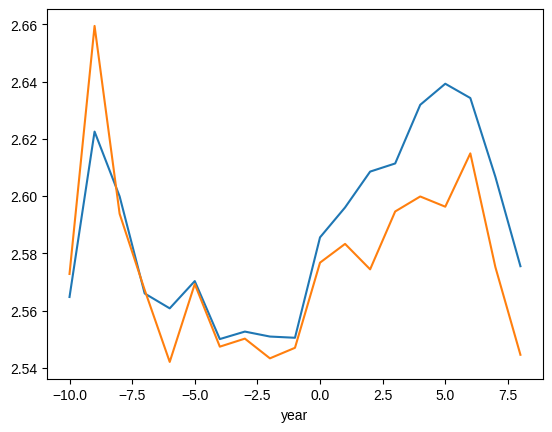

In [99]:
ss = pd.concat(out['synths'], axis=1).sort_index()
ts = pd.concat(out['treats'], axis=1).sort_index()
ss.mean(axis=1).plot()
ts.mean(axis=1).plot()

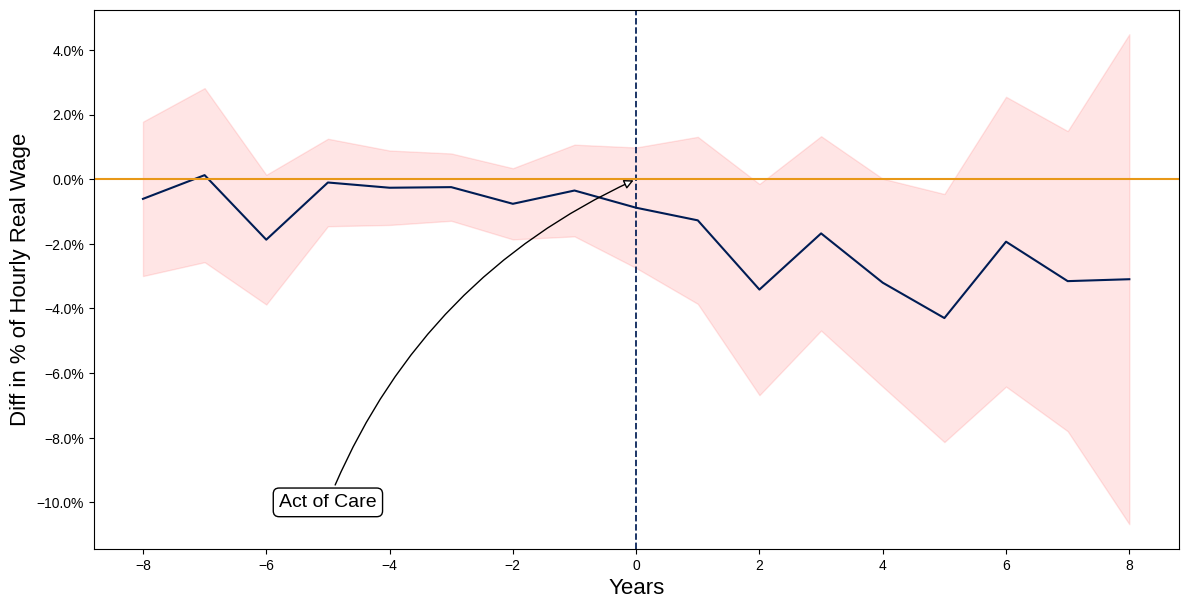

In [100]:
import math
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.pyplot import figure
mpl.rc('font', family='Liberation Sans')

figure(figsize=(14, 7))
differences = pd.concat(out['diffs'], axis=1).sort_index()[-8:8] * 100
ax = differences.mean(axis=1).plot(color='#001c54')
plt.axvline(x=0, linestyle='--', color='#001c54', alpha=1, linewidth=1.25)
plt.xlabel('Years', fontsize=16)
plt.ylabel('Diff in % of Hourly Real Wage', fontsize=16)
plt.axhline(y=0, color='#E89818', linestyle='-')
plt.fill_between(x=differences.index,
                 y1=differences.mean(axis=1) + (1.96*(differences.std(axis=1)/differences.count(axis=1).apply(math.sqrt))),
                 y2=differences.mean(axis=1) - (1.96*(differences.std(axis=1)/differences.count(axis=1).apply(math.sqrt))),
                     color='red', alpha=0.1)
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
ax.annotate("Act of Care",
            xy=(0, 0), xycoords='data',
            xytext=(-5, -10), textcoords='data',
            size=14, va="center", ha="center",
            bbox=dict(boxstyle="round", fc="w"),
            arrowprops=dict(arrowstyle="-|>", linestyle='-',
                            connectionstyle="arc3,rad=-0.2",
                            fc="w"))

plt.show()